# Simulation of model

In [1]:
import numpy as np
import pandas as pd
from sympy import symbols, solve
from scipy.optimize import fmin
import math
import matplotlib.pyplot as plt
import seaborn as sns

draw n random values for sigma

In [2]:
# number of random sigmas
np.random.seed(123)
n = 1000
# mean and sd of lognormal distribution
m, s = 0,1
sigma = np.random.lognormal(mean=m, sigma=s, size=n)
# make to list
sigma = sigma.tolist()

define values for $\pi$ and $\phi$

In [3]:
pi = 1
phi = 3

## Cost functions
fixing cost function $C(x,\sigma) = \frac{\sigma}{x}$

Text(0, 0.5, 'C(x)')

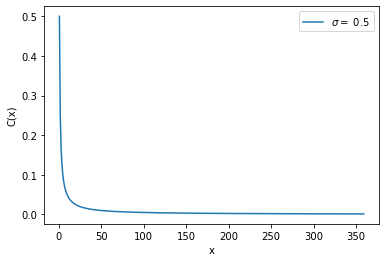

In [4]:
def C(x, sigma):
    return sigma/x


# plot for fixed sigma
sigma_fix = 0.5
x = np.arange(1,360,1)    
plt.plot(x,C(x,sigma_fix), label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x)')


Cost function $K(x,\sigma) = (\pi + \phi)x + C(x, \sigma)$ with x, $\sigma$, $\pi$ and $\phi$ as inputs

Text(0, 0.5, 'K(x)')

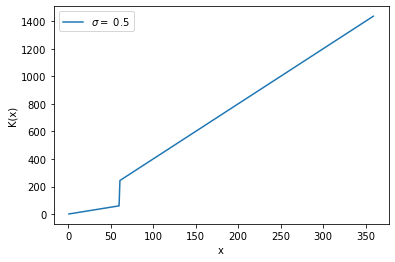

In [5]:
def K(x,sigma, pi=1, phi=0, type='scalar'):
    if x <= 60:
        exp = (pi) * x + C(x, sigma)
    elif x > 60:  
        exp = (pi + phi) * x + C(x, sigma)  
    if type == 'scalar':
        return exp
    elif type == 'math_exp':
        return math.exp(exp)


# plot K with fixed sigma 
x = np.arange(1,360,1)
Ks = [K(x,sigma = sigma_fix, pi = 1, phi = phi, type = 'scalar') for x in x]  
plt.plot(x,Ks, label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('K(x)')  

find the minimum x of K() for all sigmas

In [6]:
xstar = {}
for s in sigma:
    x = fmin(K,x0 = 0.1, args=(s,pi, phi, 'math_exp'), disp=False)
    if x < 0:
        raise ValueError('x negative')
    xstar[s] = x[0]

now put all all in a dataframe and calculate the costs for the optimal x's

In [7]:
df = pd.DataFrame.from_dict(xstar, orient='index', columns=['xstar'])
df = df.reset_index()
df = df.rename(columns={'index':'sigma'})


# calculate fixing cost C
df['fixing_cost'] = df.apply(lambda row: C(row.sigma,row.xstar), axis=1)
# calculate cost K
df['K'] = df.apply(lambda row: K(row.xstar, row.sigma), axis=1)

print('mean of x:', np.mean(df.xstar), '; variance:', np.var(df.xstar))
df.head()

mean of x: 1.110472500000004 ; variance: 0.3461050166241236


,sigma,xstar,fixing_cost,K
0,0.337689,0.581094,1.720797,1.162220
1,2.711076,1.646563,0.607347,3.293069
2,1.327077,1.151953,0.868038,2.303976
3,0.221730,0.470859,2.123571,0.941764
4,0.560683,0.748750,1.335426,1.497575


## Plots
plot the optimal $x(\sigma)$ and the functions $C(x,\sigma)$ and $K(x,\sigma)$

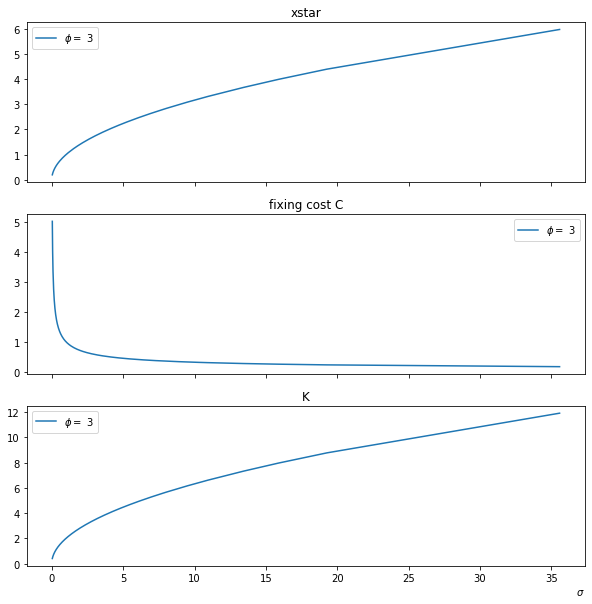

In [8]:
# first sort df in ascending order for sigmas
df_order = df.sort_values('sigma')

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(df_order.sigma, df_order.xstar, label=f'$\phi =$ {phi}')
axs[0].set_title('xstar')
axs[1].plot(df_order.sigma, df_order.fixing_cost, label=f'$\phi =$ {phi}')
axs[1].set_title('fixing cost C')
axs[2].plot(df_order.sigma, df_order.K, label=f'$\phi =$ {phi}')
axs[2].set_title('K')
axs[2].set_xlabel(r'$\sigma$', loc='right')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

density of duration x

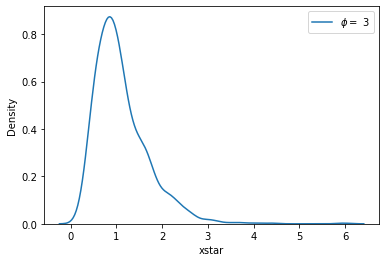

In [9]:
fig, ax = plt.subplots()
sns.kdeplot(df.xstar, label = f'$\phi =$ {phi}', ax=ax) 
plt.xlabel('xstar')
plt.legend()

## Fine Schedule

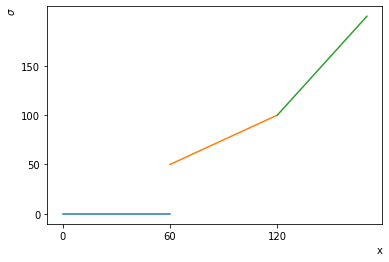

In [10]:
x0, y0 = [0,60], [0,0]
x1, y1 = [60, 120], [50,100]
x2, y2 = [120,170], [100,200]
plt.plot(x0, y0)
plt.plot(x1,y1,x2, y2)
plt.xticks([0,60,120])
plt.yticks([0,50,100,150])
plt.xlabel('x', loc = 'right')
plt.ylabel(r'$\sigma$', loc = 'top')
plt.show()

### Fine schedule tradeoff
$\pi*60 + C(60,\sigma) \geq 2(\sigma(\pi + \phi))^{1/2} = C(\sigma, \pi, \phi)$

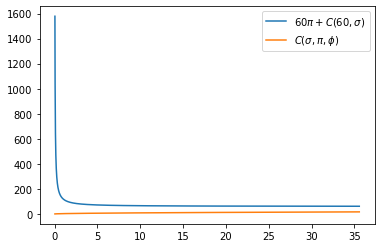

In [11]:
left = [60*pi + C(s,60) for s in sigma]
right = [np.sqrt(2*(s*(pi+phi))) for s in sigma]
tradeoff = pd.DataFrame({'sigma':sigma, 'left':left, 'right':right}).sort_values('sigma')

plt.plot(tradeoff.sigma, tradeoff.left, label = r'$60 \pi + C(60,\sigma)$')
plt.plot(tradeoff.sigma, tradeoff.right, label = r'$C(\sigma, \pi, \phi)$')
plt.legend()

solve for $\sigma$ where equality holds

In [12]:
x = symbols('s')
exp = 60*pi + C(s,60) - np.sqrt(2*(s*(pi+phi)))
sigma_bar = solve(exp)
if len(sigma_bar) > 0:
    print(f'optimal $\sigma$ is {sigma_bar[0]:.2f}')
else: print('lines do not intersect')

lines do not intersect
